# Augmentation of image samples

Purpose of the document: To provide a interface for batch processing of image augmentations across a sample extracted from all images in the input

Augmentations performed:

<ul>
    <li> Flips: Horizontal and vertical </li>
    <li> Rotation, with size preservation - 60, 120, 180, 240, 300 degrees</li>
    <li> Gaussian Noise (Salt) - p=0.01</li>
    <li> Gaussian Blur - sigma=1.5</li>
    <li> Inversion of channels - 0.4</li>
    <li> Addition of contrast - 1.25</li>
    <li> Multiply - 1.2</li>
    <li> Sharpen images - alpha = (0,0.25)</li>
    <li> Snow dust in air - p=0.029</li>
</ul>

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-required-libraries-and-images" data-toc-modified-id="Import-required-libraries-and-images-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import required libraries and images</a></span><ul class="toc-item"><li><span><a href="#Get-a-list-of-paths-for-all-images" data-toc-modified-id="Get-a-list-of-paths-for-all-images-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Get a list of paths for all images</a></span></li><li><span><a href="#Place-the-list-of-images-into-a-dataframe" data-toc-modified-id="Place-the-list-of-images-into-a-dataframe-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Place the list of images into a dataframe</a></span></li><li><span><a href="#Create-output-directories-to-store-the-augmented-images" data-toc-modified-id="Create-output-directories-to-store-the-augmented-images-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Create output directories to store the augmented images</a></span></li></ul></li><li><span><a href="#Test-a-few-augmentations" data-toc-modified-id="Test-a-few-augmentations-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Test a few augmentations</a></span></li><li><span><a href="#Define-augmentation-parameters" data-toc-modified-id="Define-augmentation-parameters-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Define augmentation parameters</a></span></li><li><span><a href="#Create-combinations-of-all-acceptable-augmentations" data-toc-modified-id="Create-combinations-of-all-acceptable-augmentations-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Create combinations of all acceptable augmentations</a></span></li><li><span><a href="#Create-a-dataframe-containing-all-possible-augmentations-for-each-image,-and-sample-it" data-toc-modified-id="Create-a-dataframe-containing-all-possible-augmentations-for-each-image,-and-sample-it-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Create a dataframe containing all possible augmentations for each image, and sample it</a></span></li><li><span><a href="#Run-Augmentations" data-toc-modified-id="Run-Augmentations-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Run Augmentations</a></span><ul class="toc-item"><li><span><a href="#Create-a-list-of-all-augmentations" data-toc-modified-id="Create-a-list-of-all-augmentations-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Create a list of all augmentations</a></span></li><li><span><a href="#Create-a-function-that-will-run-the-augmentations-for-each-image" data-toc-modified-id="Create-a-function-that-will-run-the-augmentations-for-each-image-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Create a function that will run the augmentations for each image</a></span></li><li><span><a href="#Run-the-function-using-an-apply-function" data-toc-modified-id="Run-the-function-using-an-apply-function-6.3"><span class="toc-item-num">6.3&nbsp;&nbsp;</span>Run the function using an apply function</a></span></li></ul></li><li><span><a href="#Callouts" data-toc-modified-id="Callouts-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Callouts</a></span></li></ul></div>

## Import required libraries and images

In [1]:
import os
import imutils
import cv2
import imgaug as ia
from imgaug import augmenters as iaa
import pandas as pd

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline


In [9]:
# PATH_INPUT_TRAIN = r'/Users/shyamravikumar/Documents/Workspace/BAI - Project/Input Files/Small/3. Train Test split/train'
PATH_INPUT_TRAIN = r'/Users/shyamravikumar/Documents/Workspace/BAI - Project/Input Files/V4/4. Train Test Split - Merged Categories/train'

# Path to resized & cleaned input images
PATH_OUTPUT = r'/Users/shyamravikumar/Documents/Workspace/BAI - Project/Input Files/V4/5. Augmented Images'
# CSV File containing the list of augmentations applied
PATH_MAPPING_FILES = os.path.join(PATH_OUTPUT,"list_augmentations_applied.csv")

In [10]:
SEED = 120

### Get a list of paths for all images

Ensure the paths are valid

In [47]:
check_exists_path = lambda x: os.path.exists(x)
assert(check_exists_path(PATH_INPUT_TRAIN))
assert(check_exists_path(PATH_OUTPUT))

Helper Functions to get list of images in a path, and rename them

In [11]:
def get_valid_images_in_path(path):
    """
    Return a list of valid images in a path
    
    Parameters
    ----------
        
        path: str
            Location where the images are stored
            
    Returns
    -------
        
        list of str: List of images obtained from the directory
        
    """
    from keras_preprocessing.image.utils import _iter_valid_files
    from keras_preprocessing.image.directory_iterator import DirectoryIterator
    
    list_files = list(
        _iter_valid_files(path,
                          DirectoryIterator.white_list_formats,
                          follow_links=False))
    list_files = list(map(lambda x: os.path.join(*x), list_files))
    return list_files

In [12]:
# Identify the list of available categories/classes
classes = []
for subdir in sorted(os.listdir(PATH_INPUT_TRAIN)):
    if os.path.isdir(os.path.join(PATH_INPUT_TRAIN, subdir)):
        classes.append(subdir)
classes

['defective_lav', 'defective_ldl', 'non_defective', 'non_defective_bubbles']

### Place the list of images into a dataframe

In [13]:
list_dataframes = []
for category in classes:
    path_category = os.path.join(PATH_INPUT_TRAIN, category)
    list_images = get_valid_images_in_path(path_category)
    list_dataframes.append(
        pd.DataFrame({
            'path': list_images,
            'class': np.repeat(category, len(list_images))
        })
    )

data_images = pd.concat(list_dataframes)
data_images['filename'] = data_images['path'].apply(os.path.basename)

In [14]:
data_images.sample(5)

,path,class,filename
36,/Users/shyamravikumar/Documents/Workspace/BAI ...,non_defective,nondef_62.JPG
20,/Users/shyamravikumar/Documents/Workspace/BAI ...,non_defective,nondef_38.JPG
5,/Users/shyamravikumar/Documents/Workspace/BAI ...,defective_lav,def_lav_p1_7.JPG
7,/Users/shyamravikumar/Documents/Workspace/BAI ...,defective_lav,def_lav_p2_4.JPG
10,/Users/shyamravikumar/Documents/Workspace/BAI ...,non_defective_bubbles,nondef_bubbles_24.JPG


### Create output directories to store the augmented images

In [15]:
# Ensure that the required o/p directories (for each class) exist. If not, they will be created
for feature in classes:
    folder = os.path.join(PATH_OUTPUT, feature)
    if not os.path.exists(folder):
        os.mkdir(folder)

## Test a few augmentations

In [16]:
img_input = imutils.opencv2matplotlib(cv2.imread(data_images.path.iloc[10]))

In [17]:
height=12
width=16
plt.rcParams['figure.figsize'] = (width,height)

In [20]:
# plt.imshow(img_input)

Just uncomment any one of the below, and then run the next line to view the results!

In [18]:
# augmentor = iaa.Affine(rotate=60,mode="symmetric")
# augmentor = iaa.Fliplr(1)
# augmentor = iaa.Flipud(1)
augmentor = iaa.Salt(0.01)
# augmentor = iaa.GaussianBlur(sigma=1)
# augmentor = iaa.Invert(1)
# augmentor = iaa.GammaContrast(1.25)
# augmentor = iaa.Multiply(1.2)
# augmentor = iaa.Sharpen(alpha=0.2,lightness=1) # Only sharpen
# augmentor = iaa.Add(-30) #Adjust brightness
## augmentor = iaa.AddToHueAndSaturation((-100,100)) #Adjust Hue and Saturation. Not implemented currently
# augmentor = iaa.Sequential([iaa.Flipud(1),iaa.Fliplr(1)]) #Inversion done to make snowflakes more visible

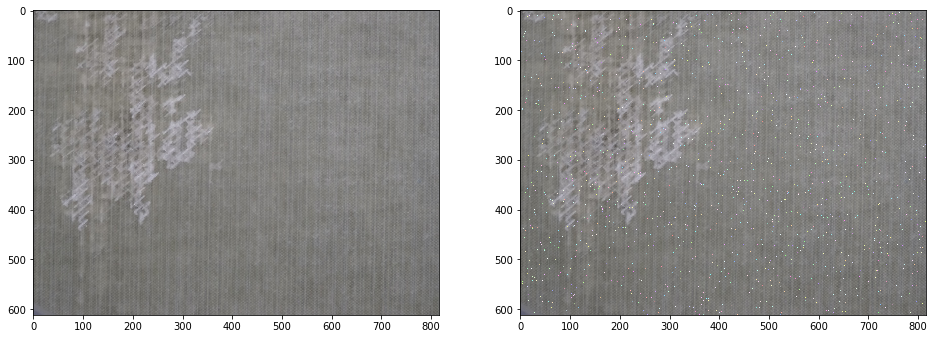

In [19]:
fig,(ax1,ax2) = plt.subplots(ncols=2)
ax1.imshow(img_input)
ax2.imshow(augmentor.augment_image(img_input))

## Define augmentation parameters

Create a dictionary of acceptable augmentations

In [20]:
acceptable_augmentations = {
    'flip_horizontal_on': iaa.Fliplr(1,name='flip_horizontal_on'),
    'flip_vertical_on': iaa.Flipud(1,name='flip_vertical_on'),
    'rotation_180': iaa.Affine(rotate=180,name='rotation_180'),
    'salt_p_0.01': iaa.Salt(0.01,name='salt_p_0.01'),
    'blur_gaussian_sigma_1': iaa.GaussianBlur(sigma=1,name='blur_gaussian_sigma_1'),
#     'invert_on': iaa.Invert(1,name='invert_on'),
    'gamma_contrast_gamma_1.25': iaa.GammaContrast(1.25,name='gamma_contrast_gamma_1.25'),
#     'multiply_mul_1.2': iaa.Multiply(1.2,name='multiply_mul_1.2'),
    'sharpen_on': iaa.Sharpen(alpha=0.2, lightness=1,name='sharpen_on'),
    'snowflakes_on': iaa.Snowflakes(0.029, speed=0.001, flake_size=(0.6, 0.8),name='snowflakes_on')
}
#Separate set of augmentations for brightness. One of these has to be used in every augmentation
# dict([('brightness_%s'%x,'iaa.Add(%s)'%x) for x in range(-60,61,10)])
#iaa.Add(0) is included so that images with original brightness are also included in the final list
acceptable_augmentations_brightness = {
#     'brightness_off': iaa.Add(0,name='brightness_off'), 
#     'brightness_-60': iaa.Add(-60,name='brightness_-60'),
#     'brightness_-50': iaa.Add(-50,name='brightness_-50'),
#     'brightness_-40': iaa.Add(-40,name='brightness_-40'),
    'brightness_-30': iaa.Add(-30,name='brightness_-30'),
#     'brightness_-20': iaa.Add(-20,name='brightness_-20'),
#     'brightness_-10': iaa.Add(-10,name='brightness_-10'),
#     'brightness_10': iaa.Add(10,name='brightness_10'),
#     'brightness_20': iaa.Add(20,name='brightness_20'),
    'brightness_30': iaa.Add(30,name='brightness_30'),
#     'brightness_40': iaa.Add(40,name='brightness_40'),
#     'brightness_50': iaa.Add(50,name='brightness_50'),
#     'brightness_60': iaa.Add(60,name='brightness_60')
}

## Create combinations of all acceptable augmentations

Logic: 
<ol>
    <li>Extract all nC1,nC2,nC3,nC4,...nCn combinations from acceptable_augmentations</li>
    <li>Take all nC2 combinations from the combination of above results with acceptable brightnesses</li>
</ol>

In [21]:
from itertools import combinations, product

In [22]:
list_augmentations = acceptable_augmentations.keys()
list_brightnesses = [(x,) for x in acceptable_augmentations_brightness.keys()]

In [23]:
# Create combinations of all augmentations excluding brightness
combinations_augmentations_phase_1 = []
for i in range(1,2):
# for i in range(1,len(list_augmentations)):
    combinations_augmentations_phase_1+= combinations(list_augmentations,i)

In [24]:
# Create combinations including brightness
combinations_augmentations_phase_2 = list(product(combinations_augmentations_phase_1,list_brightnesses))

In [25]:
print("There are %s possible combinations of augmentations for each image"%len(combinations_augmentations_phase_2))

There are 16 possible combinations of augmentations for each image


In [26]:
from itertools import chain

Get a list of all possible augmentations

In [27]:
combinations_augmentations=list(map(lambda x:tuple(chain.from_iterable(x)),combinations_augmentations_phase_2))

In [28]:
combinations_augmentations
# combinations_augmentations[500:1000:100] # Print results

[('flip_horizontal_on', 'brightness_-30'),
 ('flip_horizontal_on', 'brightness_30'),
 ('flip_vertical_on', 'brightness_-30'),
 ('flip_vertical_on', 'brightness_30'),
 ('rotation_180', 'brightness_-30'),
 ('rotation_180', 'brightness_30'),
 ('salt_p_0.01', 'brightness_-30'),
 ('salt_p_0.01', 'brightness_30'),
 ('blur_gaussian_sigma_1', 'brightness_-30'),
 ('blur_gaussian_sigma_1', 'brightness_30'),
 ('gamma_contrast_gamma_1.25', 'brightness_-30'),
 ('gamma_contrast_gamma_1.25', 'brightness_30'),
 ('sharpen_on', 'brightness_-30'),
 ('sharpen_on', 'brightness_30'),
 ('snowflakes_on', 'brightness_-30'),
 ('snowflakes_on', 'brightness_30')]

## Create a dataframe containing all possible augmentations for each image, and sample it

In [29]:
#Create a function for cross joining two datasets
def cartesian_product_simplified(left, right):
    la, lb = len(left), len(right)
    ia2, ib2 = np.broadcast_arrays(*np.ogrid[:la,:lb])

    return pd.DataFrame(
        np.column_stack([left.values[ia2.ravel()], right.values[ib2.ravel()]]))


In [30]:
data_images.shape

(89, 3)

In [31]:
res = cartesian_product_simplified(data_images,pd.DataFrame({'augmentations':combinations_augmentations}))

In [32]:
res.columns=list(data_images.columns)+['augmentations']

In [33]:
assert(res.shape[0] == data_images.shape[0] * len(combinations_augmentations))
res.shape

(1424, 4)

In [34]:
res.sample(20,random_state=SEED)

,path,class,filename,augmentations
1365,/Users/shyamravikumar/Documents/Workspace/BAI ...,non_defective_bubbles,nondef_bubbles_36.JPG,"(rotation_180, brightness_30)"
545,/Users/shyamravikumar/Documents/Workspace/BAI ...,non_defective,nondef_19.JPG,"(flip_horizontal_on, brightness_30)"
211,/Users/shyamravikumar/Documents/Workspace/BAI ...,defective_ldl,def_ldl_p1_3.JPG,"(flip_vertical_on, brightness_30)"
1134,/Users/shyamravikumar/Documents/Workspace/BAI ...,non_defective_bubbles,nondef_bubbles_12.JPG,"(snowflakes_on, brightness_-30)"
339,/Users/shyamravikumar/Documents/Workspace/BAI ...,defective_ldl,def_ldl_p3_1.JPG,"(flip_vertical_on, brightness_30)"
1333,/Users/shyamravikumar/Documents/Workspace/BAI ...,non_defective_bubbles,nondef_bubbles_34.JPG,"(rotation_180, brightness_30)"
1132,/Users/shyamravikumar/Documents/Workspace/BAI ...,non_defective_bubbles,nondef_bubbles_12.JPG,"(sharpen_on, brightness_-30)"
451,/Users/shyamravikumar/Documents/Workspace/BAI ...,non_defective,nondef_12.JPG,"(flip_vertical_on, brightness_30)"
588,/Users/shyamravikumar/Documents/Workspace/BAI ...,non_defective,nondef_21.JPG,"(sharpen_on, brightness_-30)"
1241,/Users/shyamravikumar/Documents/Workspace/BAI ...,non_defective_bubbles,nondef_bubbles_24.JPG,"(blur_gaussian_sigma_1, brightness_30)"


In [35]:
# res.to_pickle(os.path.join(PATH_OUTPUT,"list_dataset_augmentations.pickle"))
# res=pd.read_pickle(os.path.join(PATH_OUTPUT,"list_dataset_augmentations.pickle"))

In [36]:
data_sampled = res.copy()

Add a row number for each row in the dataframe, and a column to identify the augmentation

In [37]:
data_sampled.reset_index(inplace=True,drop=True)
data_sampled = data_sampled.reset_index().rename(columns={'index':'row_num'})
data_sampled['augmentation_identifier'] = 'aug_'+data_sampled['row_num'].astype('str')+'.jpg'

Add an output path for the augmented images

In [38]:
data_sampled['path_output'] = data_sampled.apply(lambda x: os.path.join(
    PATH_OUTPUT, x['class'], x['augmentation_identifier']),
                                                 axis=1)

In [39]:
print(data_sampled.shape)
data_sampled.sample(10)

(1424, 7)


,row_num,path,class,filename,augmentations,augmentation_identifier,path_output
375,375,/Users/shyamravikumar/Documents/Workspace/BAI ...,defective_ldl,def_ldl_p3_4.JPG,"(salt_p_0.01, brightness_30)",aug_375.jpg,/Users/shyamravikumar/Documents/Workspace/BAI ...
1358,1358,/Users/shyamravikumar/Documents/Workspace/BAI ...,non_defective_bubbles,nondef_bubbles_35.JPG,"(snowflakes_on, brightness_-30)",aug_1358.jpg,/Users/shyamravikumar/Documents/Workspace/BAI ...
288,288,/Users/shyamravikumar/Documents/Workspace/BAI ...,defective_ldl,def_ldl_p2_4.JPG,"(flip_horizontal_on, brightness_-30)",aug_288.jpg,/Users/shyamravikumar/Documents/Workspace/BAI ...
1184,1184,/Users/shyamravikumar/Documents/Workspace/BAI ...,non_defective_bubbles,nondef_bubbles_20.JPG,"(flip_horizontal_on, brightness_-30)",aug_1184.jpg,/Users/shyamravikumar/Documents/Workspace/BAI ...
15,15,/Users/shyamravikumar/Documents/Workspace/BAI ...,defective_lav,def_lav_p1_1.JPG,"(snowflakes_on, brightness_30)",aug_15.jpg,/Users/shyamravikumar/Documents/Workspace/BAI ...
1166,1166,/Users/shyamravikumar/Documents/Workspace/BAI ...,non_defective_bubbles,nondef_bubbles_15.JPG,"(snowflakes_on, brightness_-30)",aug_1166.jpg,/Users/shyamravikumar/Documents/Workspace/BAI ...
689,689,/Users/shyamravikumar/Documents/Workspace/BAI ...,non_defective,nondef_32.JPG,"(flip_horizontal_on, brightness_30)",aug_689.jpg,/Users/shyamravikumar/Documents/Workspace/BAI ...
1332,1332,/Users/shyamravikumar/Documents/Workspace/BAI ...,non_defective_bubbles,nondef_bubbles_34.JPG,"(rotation_180, brightness_-30)",aug_1332.jpg,/Users/shyamravikumar/Documents/Workspace/BAI ...
470,470,/Users/shyamravikumar/Documents/Workspace/BAI ...,non_defective,nondef_13.JPG,"(salt_p_0.01, brightness_-30)",aug_470.jpg,/Users/shyamravikumar/Documents/Workspace/BAI ...
1262,1262,/Users/shyamravikumar/Documents/Workspace/BAI ...,non_defective_bubbles,nondef_bubbles_26.JPG,"(snowflakes_on, brightness_-30)",aug_1262.jpg,/Users/shyamravikumar/Documents/Workspace/BAI ...


## Run Augmentations

### Create a list of all augmentations

Sample code for reference

In [40]:

# images = np.random.randint(0, 255, (16, 128, 128, 3), dtype=np.uint8)
# seq = iaa.Sequential([iaa.Fliplr(0.5), iaa.GaussianBlur((0, 3.0))])

# # Show an image with 8*8 augmented versions of image 0 and 8*8 augmented
# # versions of image 1. Identical augmentations will be applied to
# # image 0 and 1.
# seq.show_grid([images[0], images[1]], cols=2, rows=2)

### Create a function that will run the augmentations for each image

Create a function to create hooks (i.e., only certain augmentations required by each sample will be run)

In [41]:
# Create a consolidated dictionary containing definitions for all augmentations
dict_augmentations = acceptable_augmentations_brightness.copy()
for key,val in acceptable_augmentations.items():
    dict_augmentations[key]=val


def read_image(path):
    # Read an image from a path, and return the results as an array
    # Currently, the color scheme is not changed from BGR to RGB using the following line, since we are not playing with hue anywhere
    # return imutils.opencv2matplotlib(cv2.imread(path))
    return cv2.imread(path)

def get_augmentor(augmentation_labels):
    # Create an augmentor that would perform a specific set of augmentations
    temp=[dict_augmentations[label] for label in augmentation_labels]
    return iaa.Sequential(temp).to_deterministic()

def augment_and_save_image(row,flag_return_image=False):
    augmentor = get_augmentor(row['augmentations'])
    aug_img = augmentor.augment_image(read_image(row['path']))
    
    # Store the save the augmented images
    cv2.imwrite(row['path_output'],aug_img)
    if flag_return_image:
        return aug_img

Test run the functions created

In [42]:
# row = data_sampled.iloc[20]
# print(row['augmentations'])

# augmented_image = augment_and_save_image(row,flag_return_image=True)

# fig,(ax1,ax2) = plt.subplots(ncols=2)
# ax1.imshow(read_image(row['path']))
# ax2.imshow(augmented_image)

# plt.imshow(augment_and_save_image(row))

### Run the function using an apply function

In [43]:
# Export the sample data & augmentations applied, so it can be retrieved later when required
data_sampled.to_csv(PATH_MAPPING_FILES,index=False)

In [44]:
# Can simply use the apply function. I'm using tqdm to monitor progress as well
from tqdm import tqdm
tqdm.pandas()

In [45]:
temp = data_sampled.progress_apply(augment_and_save_image,axis=1)
temp.unique()
print("Augmentations have been created")

100%|██████████| 1424/1424 [01:10<00:00, 20.08it/s]


array([None], dtype=object)

Augmentations have been created


## Callouts

Note: To create model input files, some manual work has to be done post this stage:
<ol>
    <li>Create a new folder to store model input images</li>
    <li>Move all the images from train_test_split into a folder for train images inside the path from the previous bullet</li>
    <li>Move augmented images into their respective folders inside the augmented folders</li>
</ol>

This code will do the same task

In [71]:
from glob import glob
import shutil

In [46]:
# Path where the train/test folders are located
PATH_TRAIN_SPLIT = r'/Users/shyamravikumar/Documents/Workspace/BAI - Project/Input Files/V4/4. Train Test Split - Merged Categories'
# Path where the augmented images for training dataset are located
PATH_AUGMENTATIONS_TRAIN = r'/Users/shyamravikumar/Documents/Workspace/BAI - Project/Input Files/V4/5. Augmented Images'
# Path where the final results need to be placed
PATH_OUTPUT = r'/Users/shyamravikumar/Documents/Workspace/BAI - Project/Input Files/V4/6. Model Inputs'

In [53]:
path_train = os.path.join(PATH_TRAIN_SPLIT,'train')
path_test = os.path.join(PATH_TRAIN_SPLIT,'test')

Ensure the paths are valid

In [54]:
check_exists_path = lambda x: os.path.exists(x)
assert(check_exists_path(PATH_TRAIN_SPLIT))
assert(check_exists_path(path_train))
assert(check_exists_path(path_test))
assert(check_exists_path(PATH_AUGMENTATIONS_TRAIN))
assert(check_exists_path(PATH_OUTPUT))

Identify all the classes

In [60]:
# Helper function to get all the classes in a directory
def get_classes_in_dir(path_dir):
    classes = []
    for subdir in sorted(os.listdir(path_dir)):
        if os.path.isdir(os.path.join(path_dir, subdir)):
            classes.append(subdir)
    return classes

In [61]:
dir_classes = get_classes_in_dir(path_train)
dir_classes

['defective_lav', 'defective_ldl', 'non_defective', 'non_defective_bubbles']

In [62]:
# Ensure the same categories are present in the augmentation folder
assert(dir_classes == get_classes_in_dir(PATH_AUGMENTATIONS_TRAIN))

In [76]:
# Create folders for train and test images in the output directory
for model_input_type in ['train','test']:
    folder = os.path.join(PATH_OUTPUT, model_input_type)
    if not os.path.exists(folder):
        os.mkdir(folder)
    
# Ensure that the required o/p directories (for each class) exist in train & test directory. If not, they will be created
for feature in dir_classes:
    folder_train = os.path.join(PATH_OUTPUT, 'train',feature)
    if not os.path.exists(folder_train):
        os.mkdir(folder_train)
    
    folder_test = os.path.join(PATH_OUTPUT, 'test',feature)
    if not os.path.exists(folder_test):
        os.mkdir(folder_test)

In [78]:
# Helper function to copy from path A to path B
def copy_to_path(a,b):
    shutil.copyfile(a,b)

Copy images from Augmented images directory to the output test folder

In [79]:
# Copy Augmented images
for feature in dir_classes:
    for image_path in glob(os.path.join(PATH_AUGMENTATIONS_TRAIN,feature,'*')):
        path_output = os.path.join(PATH_OUTPUT, 'train',feature,os.path.basename(image_path))
        copy_to_path(image_path,path_output)

Copy images from the train_test_split directory

In [80]:
# Copy Train images
for feature in dir_classes:
    for image_path in glob(os.path.join(path_train,feature,'*')):
        path_output = os.path.join(PATH_OUTPUT, 'train',feature,os.path.basename(image_path))
        copy_to_path(image_path,path_output)
# Copy Test images
for feature in dir_classes:
    for image_path in glob(os.path.join(path_test,feature,'*')):
        path_output = os.path.join(PATH_OUTPUT, 'test',feature,os.path.basename(image_path))
        copy_to_path(image_path,path_output)

There will always be some file size differences because of minor system storage methods. Ensur ethat the difference between inputs and outputs is lesser than a threshold

In [103]:

THRESHOLD = 1 #in MBs

# Get folder size
def get_size_of(path):
    return sum(
        os.path.getsize(os.path.join(dirpath, filename))
        for dirpath, dirnames, filenames in os.walk(path)
        for filename in filenames) / (1024*1024)

# Check if the difference in folder sizes is < Threshold
assert(abs(get_size_of(PATH_OUTPUT)  - get_size_of(PATH_TRAIN_SPLIT) - get_size_of(PATH_AUGMENTATIONS_TRAIN))<=THRESHOLD)